In [109]:
import os
from pprint import pprint
import sys
import pickle

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils
from sleeprnn.data import stamp_correction

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

In [51]:
meta_data = pd.read_csv('/home/ntapia/projects/sleep-rnn/resources/datasets/moda/segments/metadata.csv', sep='\t', index_col=0)
blocks_num = meta_data[meta_data.phase == 1].groupby(by="subject_id").count()
blocks_num[blocks_num.phase == 10]["phase"]

subject_id
01-05-0001    10
01-05-0003    10
01-05-0004    10
01-05-0005    10
01-05-0006    10
01-05-0007    10
01-05-0008    10
01-05-0009    10
01-05-0010    10
01-05-0011    10
01-05-0012    10
01-05-0013    10
01-05-0014    10
01-05-0015    10
01-05-0017    10
Name: phase, dtype: int64

In [52]:
subject_id = '01-05-0001'
meta_data[meta_data.subject_id == subject_id]

,subject_id,phase,channel,fs,start_seconds,segment_seconds,border_seconds
572,01-05-0001,1,EEG C3-LER,256,2985.7734,115,30
573,01-05-0001,1,EEG C3-LER,256,3335.7813,115,30
574,01-05-0001,1,EEG C3-LER,256,3505.7813,115,30
575,01-05-0001,1,EEG C3-LER,256,3635.7852,115,30
576,01-05-0001,1,EEG C3-LER,256,3765.7852,115,30
577,01-05-0001,1,EEG C3-LER,256,8545.8477,115,30
578,01-05-0001,1,EEG C3-LER,256,8695.8477,115,30
579,01-05-0001,1,EEG C3-LER,256,8825.8516,115,30
580,01-05-0001,1,EEG C3-LER,256,9115.8555,115,30
581,01-05-0001,1,EEG C3-LER,256,9245.8555,115,30


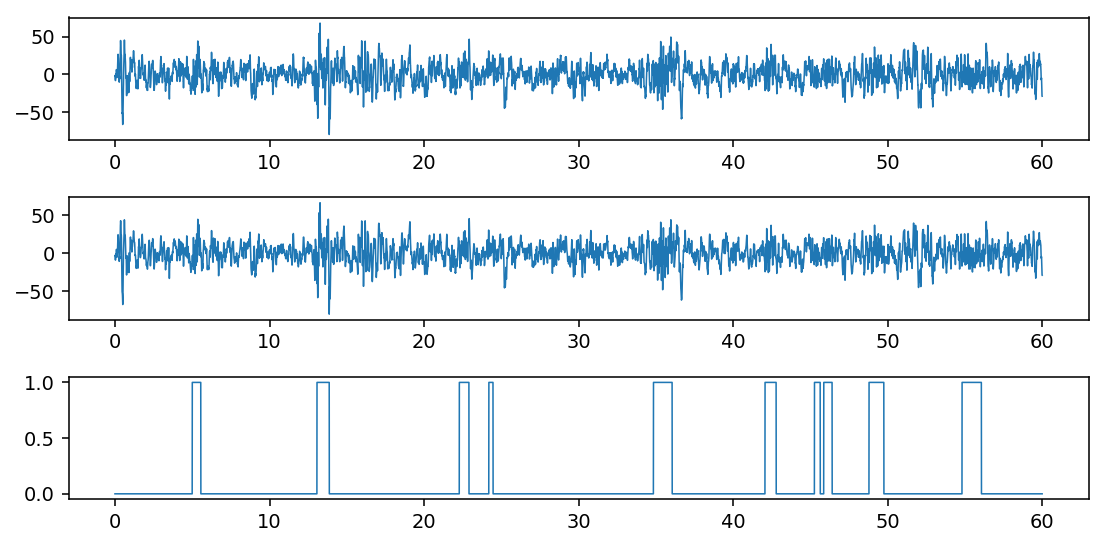

In [60]:
block_id = 572

border_seconds = 30  # s
block_seconds = 115  # s

block_data = meta_data.loc[block_id]
fs = block_data.fs
start_seconds = block_data.start_seconds
start_sample = int(fs * start_seconds)
end_sample = int(fs * block_seconds) + start_sample

border_samples = int(fs * border_seconds)

# Raw data
raw_subject_data = np.load('/home/ntapia/projects/sleep-rnn/resources/datasets/moda/signals_npz/moda_%s.npz' % subject_id)
signal_raw = raw_subject_data['signal'][start_sample:end_sample]

# Pre-processed data and labels
pre_subject_data = np.load('/home/ntapia/projects/sleep-rnn/resources/datasets/moda/segments/moda_preprocessed_segments.npz')
labels = pre_subject_data['labels'][block_id, border_samples:-border_samples]
signal_pre = pre_subject_data['signals'][block_id, border_samples:-border_samples]

# zoom-in
start_seconds = 105-60
end_seconds = 105

start_sample = int(fs * start_seconds)
end_sample = int(fs * end_seconds)

signal_raw = signal_raw[start_sample:end_sample]
signal_pre = signal_pre[start_sample:end_sample]
labels = labels[start_sample:end_sample]

# edit one label to be shorter so that it dissapears
labels = utils.seq2stamp(labels)
labels[3, 0] += int(0.1 * fs)
labels = utils.stamp2seq(labels, 0, signal_raw.size-1)

# Figure
time_axis = np.arange(labels.size) / fs
fig, axes = plt.subplots(3, 1, figsize=(8, 4), dpi=140)
axes[0].plot(time_axis, signal_raw, linewidth=0.8)
axes[1].plot(time_axis, signal_pre, linewidth=0.8)
axes[2].plot(time_axis, labels, linewidth=0.8)
plt.tight_layout()
plt.show()

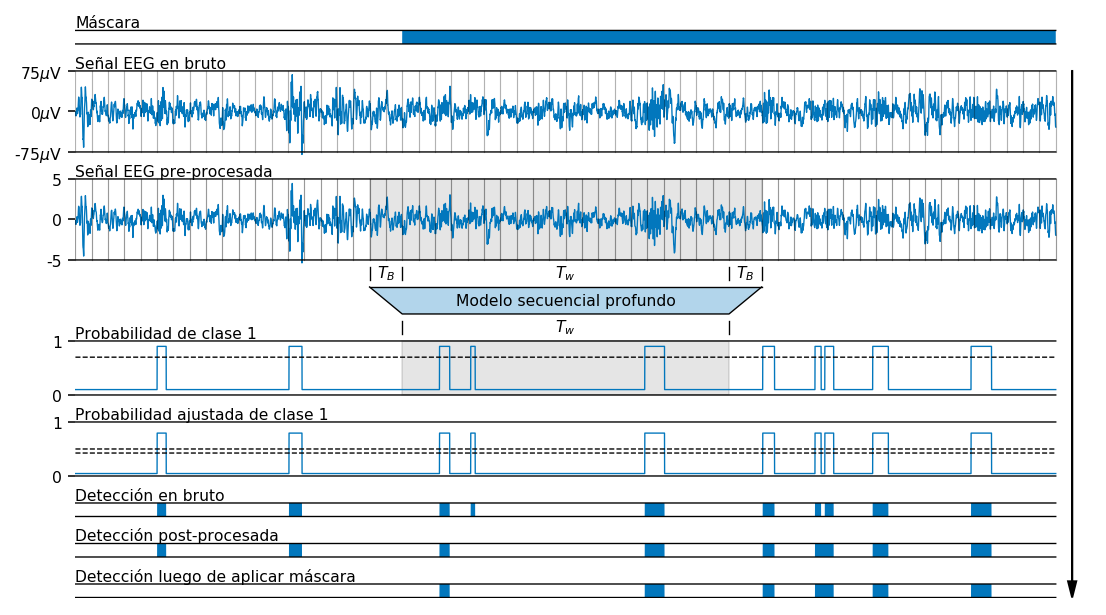

In [186]:
# big plot
n_samples = labels.size

marks = utils.seq2stamp(labels)
mask = np.ones(labels.size)
mask[:int(20 * fs)] = 0

probability_raw = np.clip(labels, a_min=0.1, a_max=0.9)
optimal_threshold = 0.7
probability_adjusted = det_utils.transform_predicted_proba_to_adjusted_proba(probability_raw, optimal_threshold, eps=1e-8)

fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), dpi=140)

sep = 0.5
width_binary = 0.25
width_proba = 1
width_signal = 1.5
width_model = 0.5
fontsize = 8

# window
start_seconds = 20
window_seconds = 20
border_seconds = 2

yticks_l = []
yticklabels_l = []

# Mask
pointer = 0
width = width_binary
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.fill_between(time_axis, pointer, pointer + width * mask, facecolor=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
ax.annotate("Máscara", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")
# yticks_l.extend([pointer, pointer + width])
# yticklabels_l.extend([0, 1])

# Signal Raw
width = width_signal
width_mV = 150
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.plot(time_axis, pointer + width / 2 + width * (signal_raw / width_mV), linewidth=0.7, color=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
yticks_l.extend([pointer, pointer + width / 2, pointer + width])
yticklabels_l.extend([
    '%d$\mu$V' % int(-width_mV/2), 
    '%d$\mu$V' % 0, 
    '%d$\mu$V' % int(width_mV/2)
])
ax.annotate("Señal EEG en bruto", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")
# One second ticks
n_seconds = int(n_samples / fs)
for i in range(n_seconds + 1):
    ax.plot([i, i], [pointer, pointer + width], linewidth=0.6, color="k", alpha=0.3)
    

# Signal pre
width = width_signal
standard_deviation = 15  # uV
width_normalized = 10
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.plot(time_axis, pointer + width / 2 + width * (signal_pre / standard_deviation / width_normalized), linewidth=0.7, color=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
yticks_l.extend([pointer, pointer + width / 2, pointer + width])
yticklabels_l.extend([int(-width_normalized/2), 0, int(width_normalized/2)])
ax.annotate("Señal EEG pre-procesada", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")
# One second ticks
n_seconds = int(n_samples / fs)
for i in range(n_seconds + 1):
    ax.plot([i, i], [pointer, pointer + width], linewidth=0.6, color="k", alpha=0.4)
ax.fill_between(
    [start_seconds - border_seconds, start_seconds + window_seconds + border_seconds],
    [pointer] * 2, [pointer + width] * 2,
    color="k", alpha=0.1
)
    
# Model
width = width_model
pointer = pointer - width - sep


seconds_to_mark = [
    start_seconds - border_seconds, 
    start_seconds,
    start_seconds + window_seconds, 
    start_seconds + window_seconds + border_seconds]
for s in seconds_to_mark:
    ax.plot([s, s], [pointer + width + sep * 0.75, pointer + width + sep * 0.25], linewidth=0.7, color="k")
seconds_to_mark = [
    start_seconds,
    start_seconds + window_seconds]
for s in seconds_to_mark:
    ax.plot([s, s], [pointer - sep * 0.75, pointer - sep * 0.25], linewidth=0.7, color="k")

ax.plot(
    [start_seconds - border_seconds, start_seconds + window_seconds + border_seconds],
    [pointer + width] * 2,
    linewidth=0.7, color="k"
)
ax.plot(
    [
        start_seconds - border_seconds, 
        start_seconds,
        start_seconds + window_seconds, 
        start_seconds + window_seconds + border_seconds],
    [pointer + width, pointer, pointer, pointer + width],
    linewidth=0.7, color="k"
)
ax.fill_between(
    [
        start_seconds - border_seconds, 
        start_seconds,
        start_seconds + window_seconds, 
        start_seconds + window_seconds + border_seconds],
    [pointer + width, pointer, pointer, pointer + width],
    [pointer + width] * 4,
    facecolor=viz.PALETTE['blue'], alpha=0.3,
)
ax.annotate("Modelo secuencial profundo", (n_seconds/2, pointer + width/2), fontsize=fontsize, ha="center", va="center")
ax.annotate("$T_w$", (n_seconds/2, pointer + width + sep/2), fontsize=fontsize, ha="center", va="center")
ax.annotate("$T_B$", (start_seconds - border_seconds/2, pointer + width + sep/2), fontsize=fontsize, ha="center", va="center")
ax.annotate("$T_B$", (start_seconds + window_seconds + border_seconds/2, pointer + width + sep/2), fontsize=fontsize, ha="center", va="center")
ax.annotate("$T_w$", (n_seconds/2, pointer - sep/2), fontsize=fontsize, ha="center", va="center")

# Probability raw
width = width_proba
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.plot(time_axis, pointer + width * probability_raw, color=viz.PALETTE['blue'], linewidth=0.7)
ax.plot(time_axis, [pointer + width * optimal_threshold] * n_samples, color="k", linewidth=0.7, linestyle="--")
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
yticks_l.extend([pointer, pointer + width])
yticklabels_l.extend([0, 1])
ax.annotate("Probabilidad de clase 1", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")

ax.fill_between(
    [start_seconds, start_seconds + window_seconds],
    [pointer] * 2, [pointer + width] * 2,
    color="k", alpha=0.1
)

# Probability adjusted
width = width_proba
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.plot(time_axis, pointer + width * probability_adjusted, color=viz.PALETTE['blue'], linewidth=0.7)
ax.plot(time_axis, [pointer + width * 0.5] * n_samples, color="k", linewidth=0.7, linestyle="--")
ax.plot(time_axis, [pointer + width * (0.5 * 0.85)] * n_samples, color="k", linewidth=0.7, linestyle="--")
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
yticks_l.extend([pointer, pointer + width])
yticklabels_l.extend([0, 1])
ax.annotate("Probabilidad ajustada de clase 1", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")

# Deteccion raw
low_thr_factor = 0.85
low_thr = 0.5 * low_thr_factor
proba_data_bin_high = (probability_adjusted >= 0.5).astype(np.int32)
proba_data_bin_low = (probability_adjusted >= low_thr).astype(np.int32)
stamps_low = utils.seq2stamp(proba_data_bin_low)
stamps_high = utils.seq2stamp(proba_data_bin_high)
overlap_check = utils.get_overlap_matrix(stamps_low, stamps_high)  # shape (n_low, n_high)
overlap_check = overlap_check.sum(axis=1)  # shape (n_low,)
valid_lows = np.where(overlap_check > 0)[0]
stamps = stamps_low[valid_lows]
stamps_to_plot = utils.stamp2seq(stamps, 0, n_samples-1)

width = width_binary
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.fill_between(time_axis, pointer, pointer + width * stamps_to_plot, facecolor=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
#yticks_l.extend([pointer, pointer + width])
#yticklabels_l.extend([0, 1])
ax.annotate("Detección en bruto", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")

# Detection post
stamps = stamp_correction.combine_close_stamps(stamps, fs, 0.3)
stamps = stamp_correction.filter_duration_stamps(stamps, fs, 0.3, 3.0, repair_long=True)
stamps_to_plot = utils.stamp2seq(stamps, 0, n_samples-1)

width = width_binary
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.fill_between(time_axis, pointer, pointer + width * stamps_to_plot, facecolor=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
#yticks_l.extend([pointer, pointer + width])
#yticklabels_l.extend([0, 1])
ax.annotate("Detección post-procesada", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")

# Mask application
new_stamps = []
for s in stamps:
    if np.any(mask[s[0]:s[1]+1]):
        new_stamps.append(s)
stamps = np.stack(new_stamps, axis=0)
stamps_to_plot = utils.stamp2seq(stamps, 0, n_samples-1)

width = width_binary
pointer = pointer - width - sep
ax.plot(time_axis, [pointer + width] * n_samples, linewidth=0.7, color="k")
ax.fill_between(time_axis, pointer, pointer + width * stamps_to_plot, facecolor=viz.PALETTE['blue'])
ax.plot(time_axis, [pointer] * n_samples, linewidth=0.7, color="k")
#yticks_l.extend([pointer, pointer + width])
#yticklabels_l.extend([0, 1])
ax.annotate("Detección luego de aplicar máscara", (0, pointer + width), fontsize=fontsize, ha="left", va="bottom")

# Rest of config
ax.set_yticks(yticks_l)
ax.set_yticklabels(yticklabels_l)
ax.tick_params(labelsize=fontsize)
ax.set_xticks([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([0, n_seconds + 2])
ax.set_ylim([pointer, sep])

# Arrow for flow
ax.arrow(n_seconds + 1, -sep, 0, pointer + sep, length_includes_head=True, head_width=0.5, width=0.01, ec='k', color="k", head_length=0.3)

plt.tight_layout()

# Save figure

plt.show()